
# Cash Drag Data: Deep EDA (Model-Agnostic)

This notebook is an exploratory pass before choosing any causal model.
It prioritizes data understanding, summary statistics, and diagnostics.


### Variable Names Used In Charts (Reader-Friendly)
- `Any Nudge Exposure`: exposed to at least one nudge in a month.
- `Investment Action (Observed)`: observed monthly investment indicator.
- `Exposure Intensity`: number of channels exposed in that month.
- `Lifecycle Month`: months since rollover.


## 1) Setup

In [66]:
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "data").exists() and (PROJECT_ROOT / "cash_drag" / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT / "cash_drag"

DATA_DIR = PROJECT_ROOT / "data"
FIG_DIR = PROJECT_ROOT / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

SAVE_FIGURES = False

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"DATA_DIR: {DATA_DIR}")
print(f"SAVE_FIGURES: {SAVE_FIGURES}")

from IPython import get_ipython

ip = get_ipython()
if ip is not None:
    ip.run_line_magic("matplotlib", "inline")

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["figure.dpi"] = 120


PROJECT_ROOT: /Users/jay/Documents/Projects/cash_drag
DATA_DIR: /Users/jay/Documents/Projects/cash_drag/data
SAVE_FIGURES: False


## 2) Load Data

In [67]:

accounts = pd.read_csv(DATA_DIR / "accounts.csv")
panel = pd.read_csv(DATA_DIR / "account_month.csv")
campaigns = pd.read_csv(DATA_DIR / "nudge_campaigns.csv")

accounts["rollover_month"] = pd.to_datetime(accounts["rollover_month"], errors="coerce")
for col in ["calendar_month", "first_exposure_month"]:
    panel[col] = pd.to_datetime(panel[col], errors="coerce")
for col in ["start_month", "end_month"]:
    campaigns[col] = pd.to_datetime(campaigns[col], errors="coerce")

panel["exposed_any"] = (
    (panel["exposure_email"] == 1)
    | (panel["exposure_sms"] == 1)
    | (panel["exposure_inapp"] == 1)
).astype(int)

print("accounts:", accounts.shape)
print("panel:", panel.shape)
print("campaigns:", campaigns.shape)


accounts: (50000, 13)
panel: (1800000, 32)
campaigns: (12, 7)


## 3) Dataset Inventory

In [68]:

inventory = pd.DataFrame([
    {
        "dataset": "accounts",
        "rows": len(accounts),
        "cols": accounts.shape[1],
        "unique_accounts": accounts["account_id"].nunique(),
        "min_month": accounts["rollover_month"].min(),
        "max_month": accounts["rollover_month"].max(),
    },
    {
        "dataset": "account_month",
        "rows": len(panel),
        "cols": panel.shape[1],
        "unique_accounts": panel["account_id"].nunique(),
        "min_month": panel["calendar_month"].min(),
        "max_month": panel["calendar_month"].max(),
    },
    {
        "dataset": "nudge_campaigns",
        "rows": len(campaigns),
        "cols": campaigns.shape[1],
        "unique_accounts": np.nan,
        "min_month": campaigns["start_month"].min(),
        "max_month": campaigns["end_month"].max(),
    },
])
inventory


,dataset,rows,cols,unique_accounts,min_month,max_month
0,accounts,50000,13,50000.0,1970-01-01 00:00:00.000000001,1970-01-01 00:00:00.000000012
1,account_month,1800000,32,50000.0,1970-01-01 00:00:00.000000001,1970-01-01 00:00:00.000000036
2,nudge_campaigns,12,7,NaN,1970-01-01 00:00:00.000000004,1970-01-01 00:00:00.000000027


## 4) Summary Statistics (Tabular-First EDA)

In [69]:

def numeric_summary(df, cols, quantiles=(0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99)):
    use_cols = [col for col in cols if col in df.columns]
    desc = df[use_cols].describe(percentiles=list(quantiles)).T
    desc = desc.rename(columns={
        "count": "non_missing_n",
        "mean": "mean",
        "std": "std",
        "min": "min",
        "1%": "p01",
        "5%": "p05",
        "25%": "p25",
        "50%": "p50",
        "75%": "p75",
        "95%": "p95",
        "99%": "p99",
        "max": "max",
    })
    desc["missing_n"] = len(df) - desc["non_missing_n"]
    desc["missing_rate"] = df[use_cols].isna().mean().values
    ordered = ["non_missing_n", "missing_n", "missing_rate", "mean", "std", "min", "p01", "p05", "p25", "p50", "p75", "p95", "p99", "max"]
    return desc[ordered].sort_index()


def categorical_summary(df, col, top_k=10):
    counts = df[col].astype("object").fillna("<NA>").value_counts(dropna=False).head(top_k)
    out = counts.rename("count").to_frame()
    out["share"] = out["count"] / len(df)
    out.index.name = col
    return out


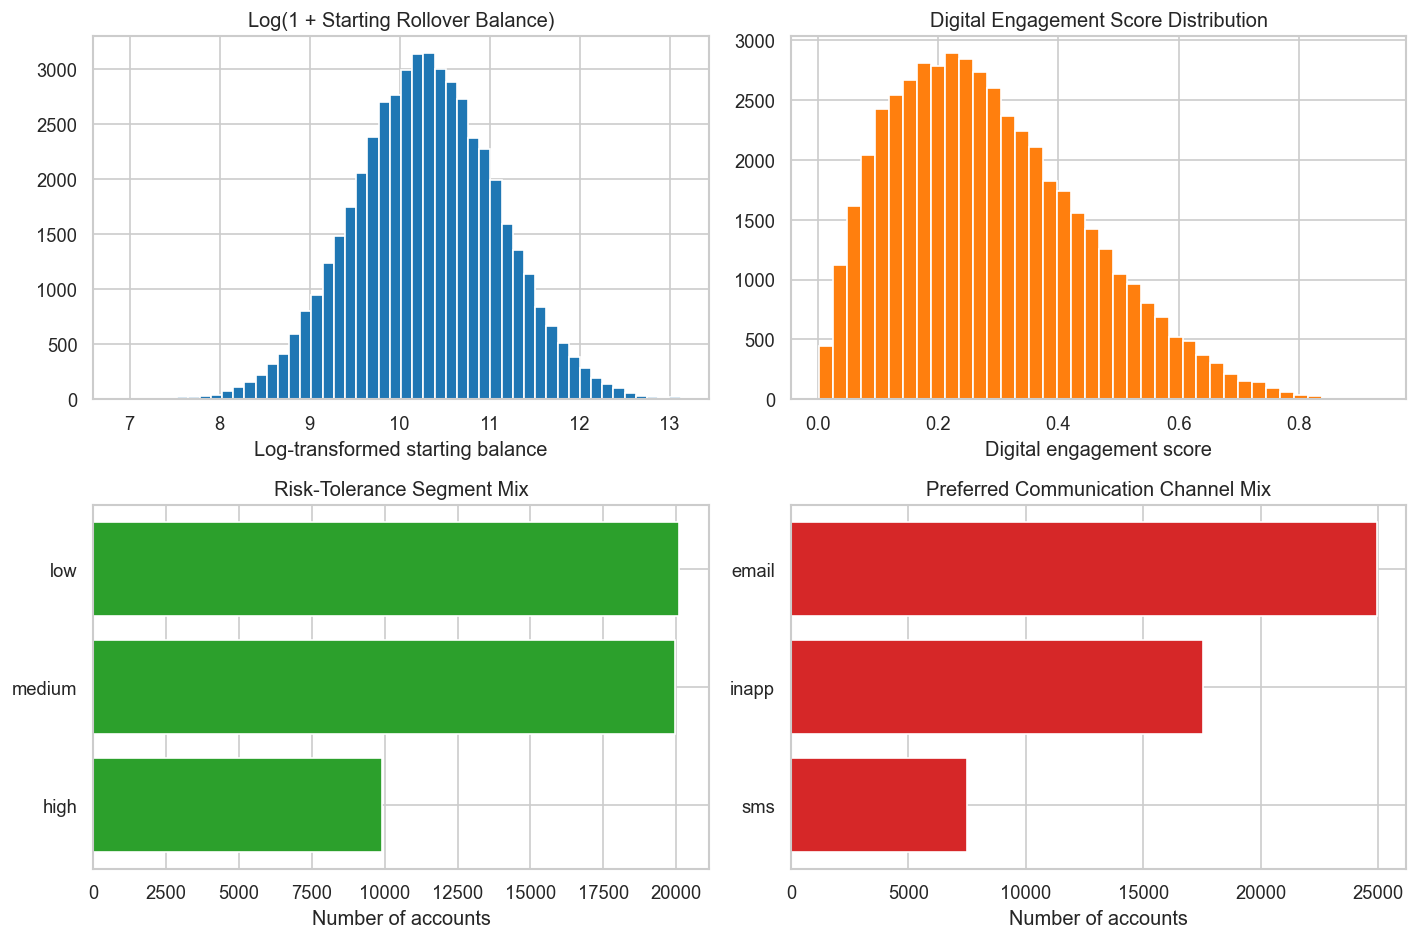

In [70]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

bal = accounts["baseline_balance"].clip(lower=0)
axes[0, 0].hist(np.log1p(bal), bins=50, color="#1f77b4")
axes[0, 0].set_title("Log(1 + Starting Rollover Balance)")
axes[0, 0].set_xlabel("Log-transformed starting balance")

axes[0, 1].hist(accounts["digital_engagement_score"], bins=40, color="#ff7f0e")
axes[0, 1].set_title("Digital Engagement Score Distribution")
axes[0, 1].set_xlabel("Digital engagement score")

risk_counts = accounts["risk_tolerance"].value_counts().sort_values()
axes[1, 0].barh(risk_counts.index, risk_counts.values, color="#2ca02c")
axes[1, 0].set_title("Risk-Tolerance Segment Mix")
axes[1, 0].set_xlabel("Number of accounts")

channel_counts = accounts["preferred_channel"].value_counts().sort_values()
axes[1, 1].barh(channel_counts.index, channel_counts.values, color="#d62728")
axes[1, 1].set_title("Preferred Communication Channel Mix")
axes[1, 1].set_xlabel("Number of accounts")

plt.tight_layout()
if SAVE_FIGURES:
    fig.savefig(FIG_DIR / "eda_account_distributions.png", dpi=150, bbox_inches="tight")
plt.show()


In [71]:

binary_cols = [
    "active_flag",
    "eligible_flag",
    "treatment_any",
    "exposed_any",
    "invested_flag",
    "account_closed",
    "missing_engagement",
    "missing_market_return",
]

binary_rate_summary = pd.DataFrame({
    "mean_rate": panel[binary_cols].mean(),
    "missing_rate": panel[binary_cols].isna().mean(),
    "non_missing_n": panel[binary_cols].notna().sum(),
}).sort_values("mean_rate", ascending=False)

binary_rate_summary.round(4)


,mean_rate,missing_rate,non_missing_n
active_flag,0.8474,0.0,1800000
missing_engagement,0.0501,0.0,1800000
eligible_flag,0.0445,0.0,1800000
invested_flag,0.0366,0.0,1800000
missing_market_return,0.0200,0.0,1800000
account_closed,0.0179,0.0,1800000
treatment_any,0.0058,0.0,1800000
exposed_any,0.0058,0.0,1800000


In [72]:

categorical_cols = [
    "age_band",
    "tenure_band",
    "risk_tolerance",
    "region",
    "preferred_channel",
]

for col in categorical_cols:
    print(f"\nTop levels: {col}")
    display(categorical_summary(accounts, col, top_k=10).round(4))



Top levels: age_band


,count,share
age_band,,
50-64,15055,0.3011
35-49,14983,0.2997
65+,10022,0.2004
18-34,9940,0.1988



Top levels: tenure_band


,count,share
tenure_band,,
0-2y,17622,0.3524
3-5y,17351,0.3470
6y+,15027,0.3005



Top levels: risk_tolerance


,count,share
risk_tolerance,,
low,20111,0.4022
medium,19973,0.3995
high,9916,0.1983



Top levels: region


,count,share
region,,
North,12582,0.2516
West,12528,0.2506
East,12450,0.2490
South,12440,0.2488



Top levels: preferred_channel


,count,share
preferred_channel,,
email,24943,0.4989
inapp,17547,0.3509
sms,7510,0.1502


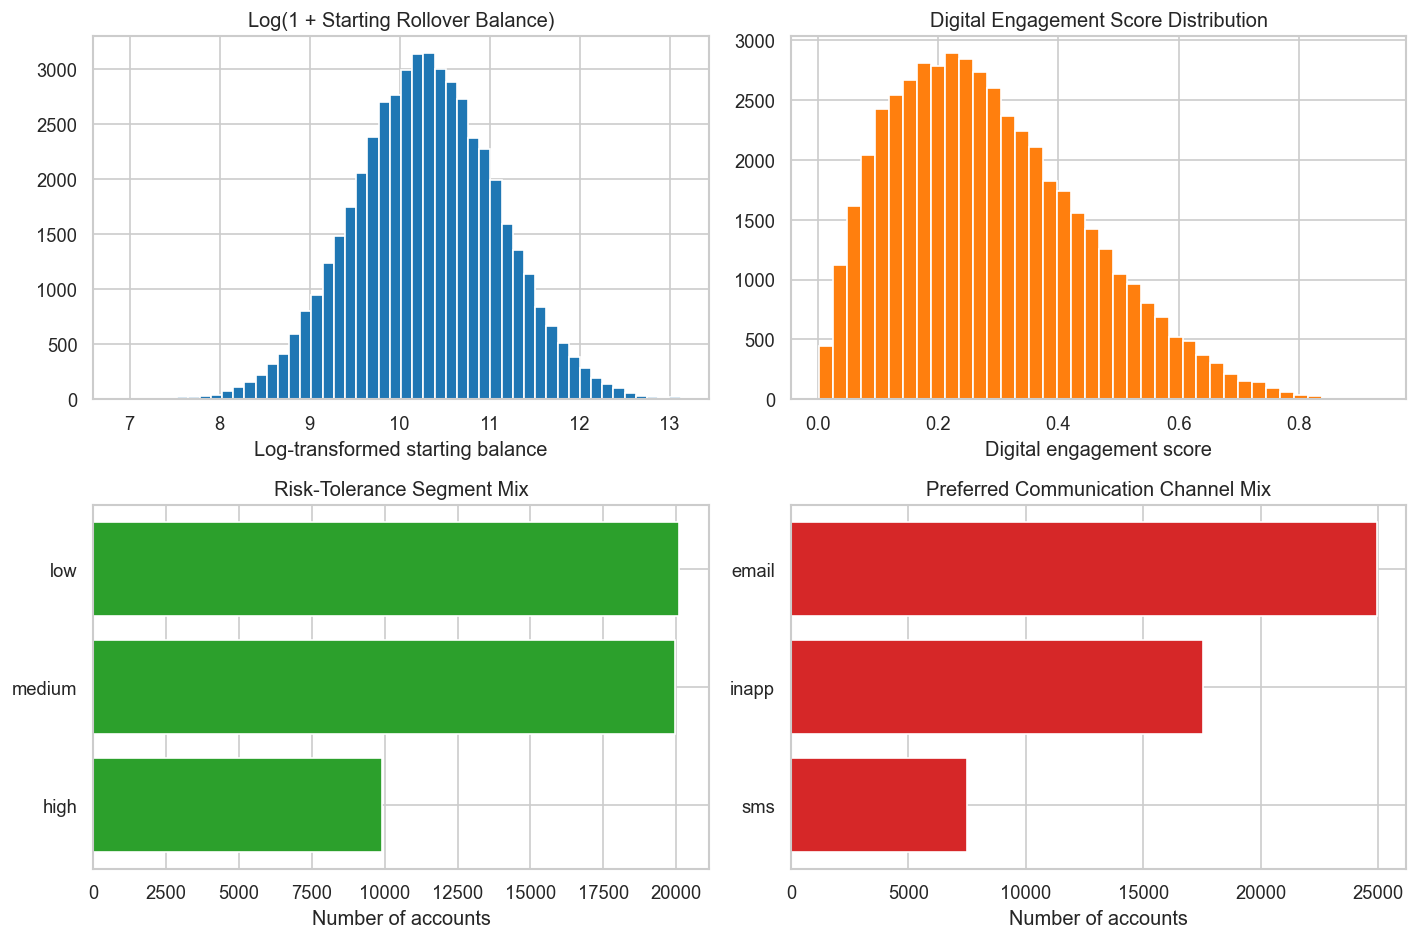

In [73]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

bal = accounts["baseline_balance"].clip(lower=0)
axes[0, 0].hist(np.log1p(bal), bins=50, color="#1f77b4")
axes[0, 0].set_title("Log(1 + Starting Rollover Balance)")
axes[0, 0].set_xlabel("Log-transformed starting balance")

axes[0, 1].hist(accounts["digital_engagement_score"], bins=40, color="#ff7f0e")
axes[0, 1].set_title("Digital Engagement Score Distribution")
axes[0, 1].set_xlabel("Digital engagement score")

risk_counts = accounts["risk_tolerance"].value_counts().sort_values()
axes[1, 0].barh(risk_counts.index, risk_counts.values, color="#2ca02c")
axes[1, 0].set_title("Risk-Tolerance Segment Mix")
axes[1, 0].set_xlabel("Number of accounts")

channel_counts = accounts["preferred_channel"].value_counts().sort_values()
axes[1, 1].barh(channel_counts.index, channel_counts.values, color="#d62728")
axes[1, 1].set_title("Preferred Communication Channel Mix")
axes[1, 1].set_xlabel("Number of accounts")

plt.tight_layout()
if SAVE_FIGURES:
    fig.savefig(FIG_DIR / "eda_account_distributions.png", dpi=150, bbox_inches="tight")
plt.show()


## 5) Key Integrity and Panel Structure

In [74]:

dup_accounts = accounts.duplicated(subset=["account_id"]).sum()
dup_panel_keys = panel.duplicated(subset=["account_id", "calendar_month"]).sum()

months_per_account = panel.groupby("account_id")["calendar_month"].nunique()

panel_summary = pd.DataFrame({
    "check": [
        "Duplicate account_id in accounts",
        "Duplicate (account_id, calendar_month) in panel",
        "Accounts with < 36 monthly rows",
        "Accounts with > 36 monthly rows",
    ],
    "value": [
        int(dup_accounts),
        int(dup_panel_keys),
        int((months_per_account < 36).sum()),
        int((months_per_account > 36).sum()),
    ],
})
panel_summary


,check,value
0,Duplicate account_id in accounts,0
1,"Duplicate (account_id, calendar_month) in panel",0
2,Accounts with < 36 monthly rows,0
3,Accounts with > 36 monthly rows,0


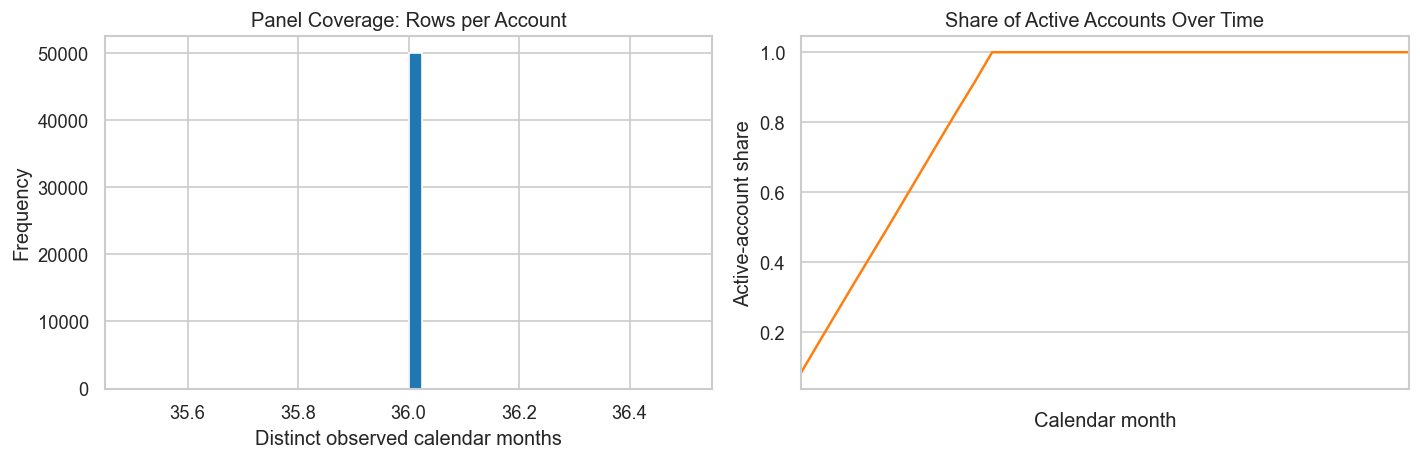

In [75]:

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
months_per_account.plot(kind="hist", bins=40, ax=axes[0], color="#1f77b4")
axes[0].set_title("Panel Coverage: Rows per Account")
axes[0].set_xlabel("Distinct observed calendar months")

active_share = panel.groupby("calendar_month")["active_flag"].mean()
active_share.plot(ax=axes[1], color="#ff7f0e")
axes[1].set_title("Share of Active Accounts Over Time")
axes[1].set_xlabel("Calendar month")
axes[1].set_ylabel("Active-account share")

plt.tight_layout()
if SAVE_FIGURES:
    fig.savefig(FIG_DIR / "eda_panel_integrity.png", dpi=150, bbox_inches="tight")
plt.show()


## 6) Missingness and Observability

In [76]:

missing_df = (
    panel.isna().mean()
    .sort_values(ascending=False)
    .rename("missing_rate")
    .reset_index()
    .rename(columns={"index": "column"})
)

missing_df.head(20)


,column,missing_rate
0,event_time,0.867294
1,engagement_obs,0.050108
2,market_return_obs,0.020017
3,account_id,0.000000
4,calendar_month,0.000000
5,missing_market_return,0.000000
6,missing_engagement,0.000000
7,account_closed,0.000000
8,invest_amount,0.000000
9,invested_status,0.000000


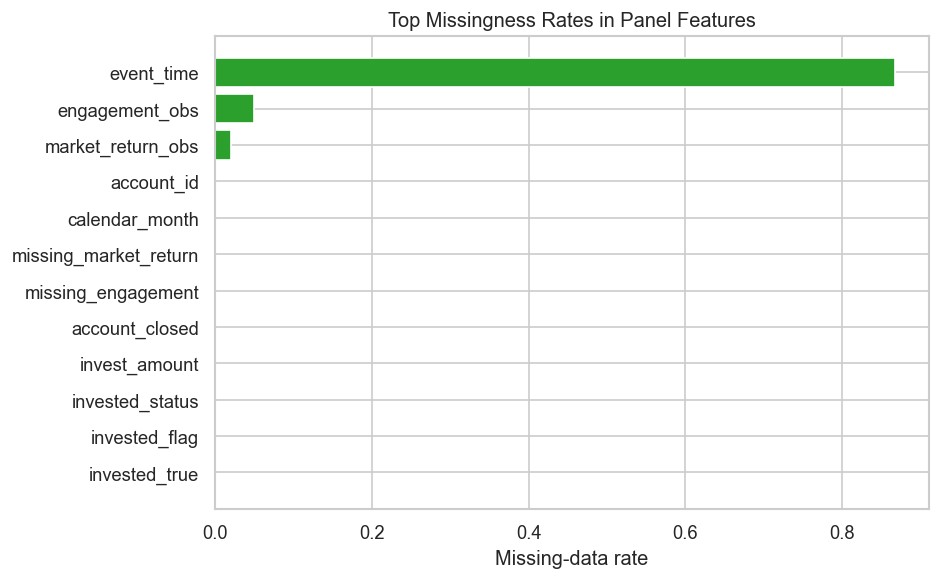

In [77]:

top_missing = missing_df.head(12).iloc[::-1]
fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(top_missing["column"], top_missing["missing_rate"], color="#2ca02c")
ax.set_title("Top Missingness Rates in Panel Features")
ax.set_xlabel("Missing-data rate")

plt.tight_layout()
if SAVE_FIGURES:
    fig.savefig(FIG_DIR / "eda_missingness_top12.png", dpi=150, bbox_inches="tight")
plt.show()


## 7) Domain Sanity Checks

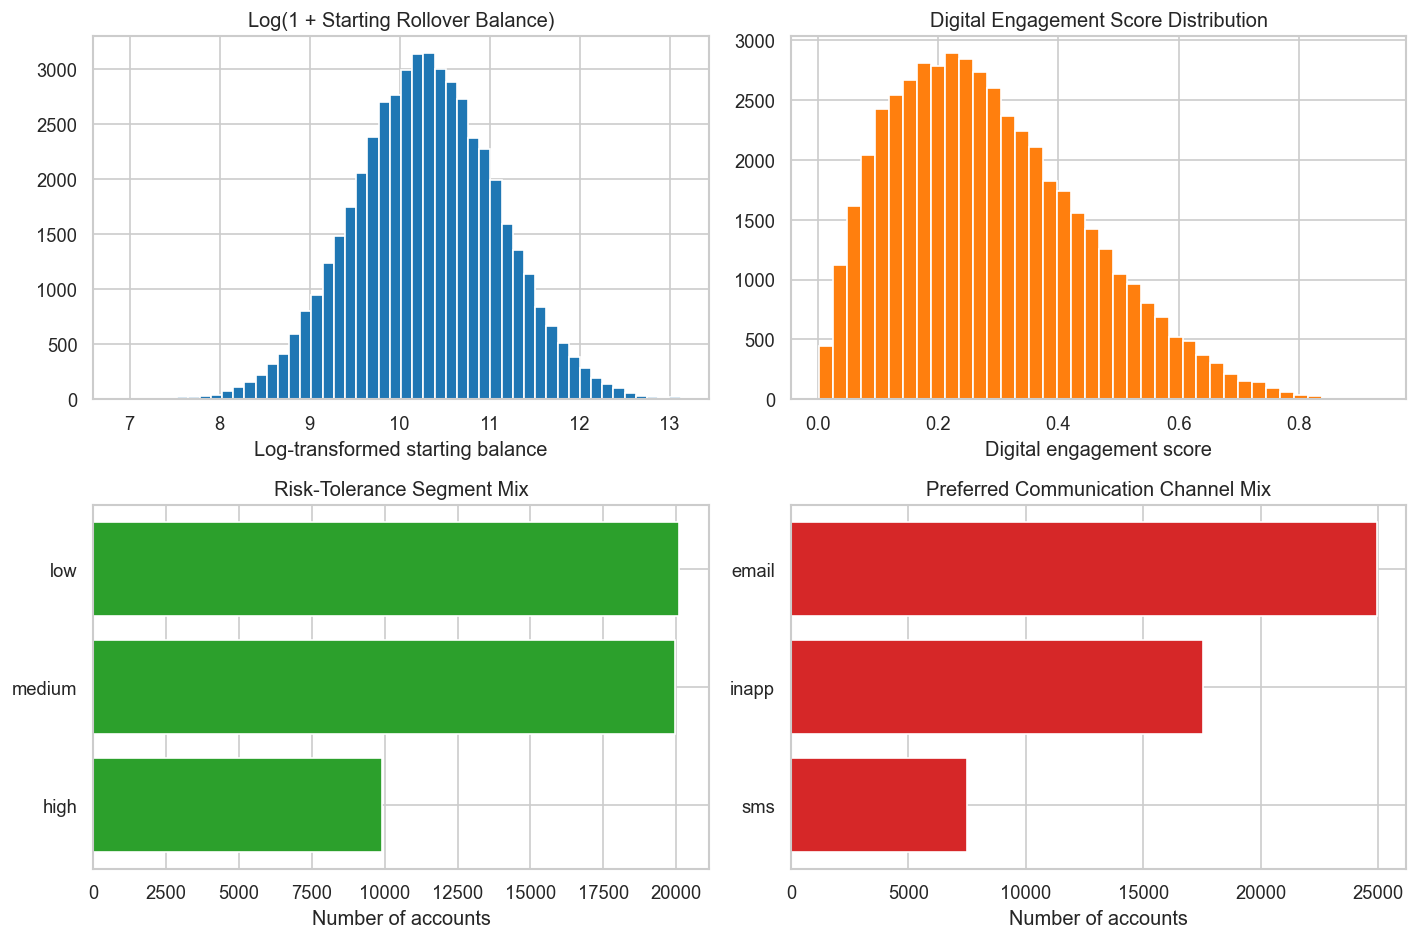

In [78]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

bal = accounts["baseline_balance"].clip(lower=0)
axes[0, 0].hist(np.log1p(bal), bins=50, color="#1f77b4")
axes[0, 0].set_title("Log(1 + Starting Rollover Balance)")
axes[0, 0].set_xlabel("Log-transformed starting balance")

axes[0, 1].hist(accounts["digital_engagement_score"], bins=40, color="#ff7f0e")
axes[0, 1].set_title("Digital Engagement Score Distribution")
axes[0, 1].set_xlabel("Digital engagement score")

risk_counts = accounts["risk_tolerance"].value_counts().sort_values()
axes[1, 0].barh(risk_counts.index, risk_counts.values, color="#2ca02c")
axes[1, 0].set_title("Risk-Tolerance Segment Mix")
axes[1, 0].set_xlabel("Number of accounts")

channel_counts = accounts["preferred_channel"].value_counts().sort_values()
axes[1, 1].barh(channel_counts.index, channel_counts.values, color="#d62728")
axes[1, 1].set_title("Preferred Communication Channel Mix")
axes[1, 1].set_xlabel("Number of accounts")

plt.tight_layout()
if SAVE_FIGURES:
    fig.savefig(FIG_DIR / "eda_account_distributions.png", dpi=150, bbox_inches="tight")
plt.show()


## 8) Distributional Profile (Account Level)

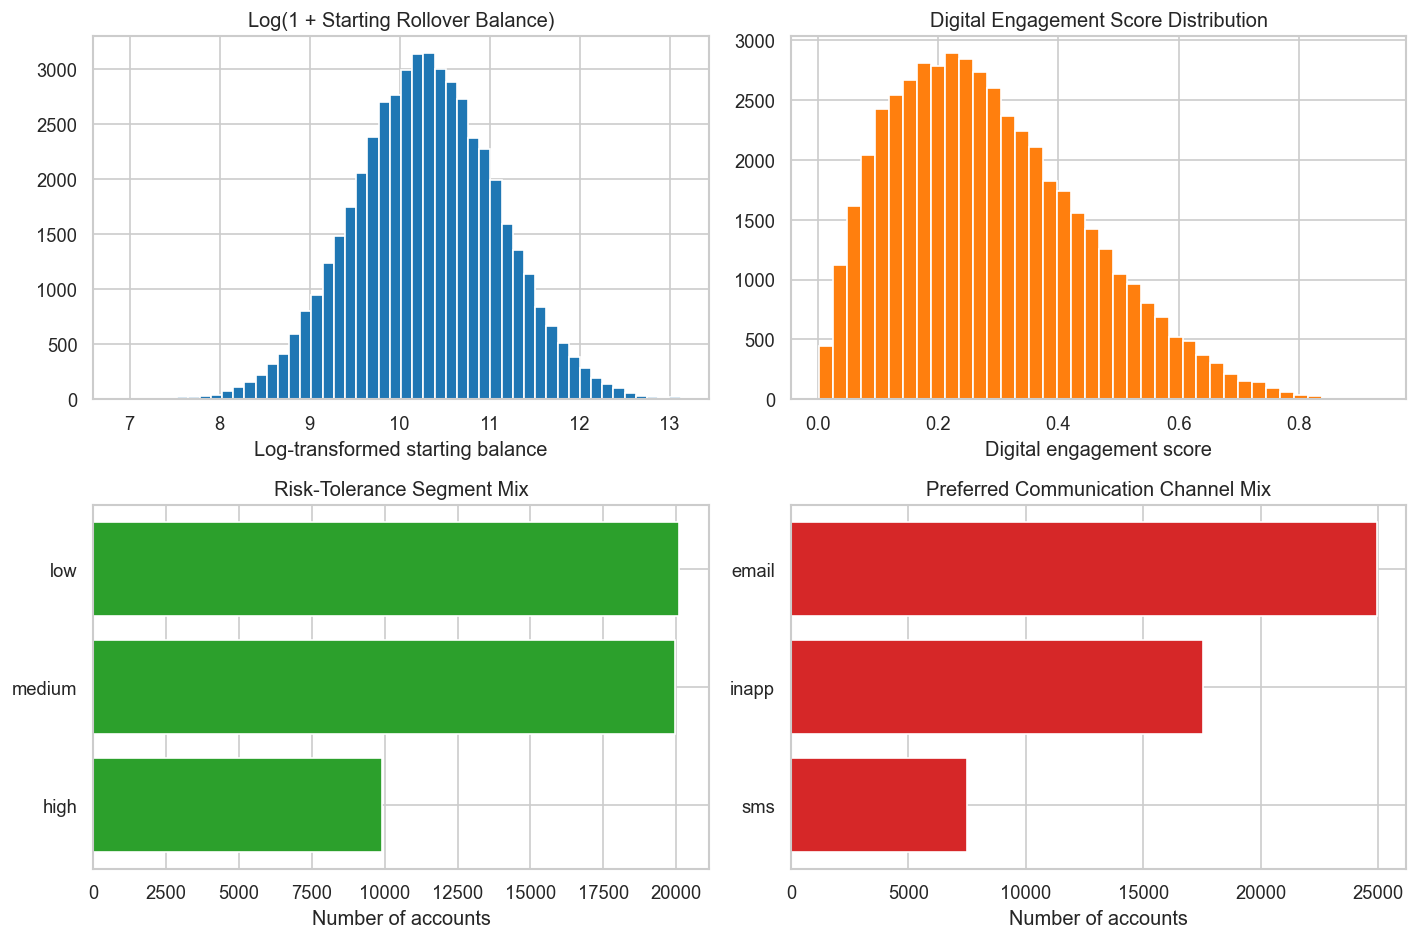

In [79]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

bal = accounts["baseline_balance"].clip(lower=0)
axes[0, 0].hist(np.log1p(bal), bins=50, color="#1f77b4")
axes[0, 0].set_title("Log(1 + Starting Rollover Balance)")
axes[0, 0].set_xlabel("Log-transformed starting balance")

axes[0, 1].hist(accounts["digital_engagement_score"], bins=40, color="#ff7f0e")
axes[0, 1].set_title("Digital Engagement Score Distribution")
axes[0, 1].set_xlabel("Digital engagement score")

risk_counts = accounts["risk_tolerance"].value_counts().sort_values()
axes[1, 0].barh(risk_counts.index, risk_counts.values, color="#2ca02c")
axes[1, 0].set_title("Risk-Tolerance Segment Mix")
axes[1, 0].set_xlabel("Number of accounts")

channel_counts = accounts["preferred_channel"].value_counts().sort_values()
axes[1, 1].barh(channel_counts.index, channel_counts.values, color="#d62728")
axes[1, 1].set_title("Preferred Communication Channel Mix")
axes[1, 1].set_xlabel("Number of accounts")

plt.tight_layout()
if SAVE_FIGURES:
    fig.savefig(FIG_DIR / "eda_account_distributions.png", dpi=150, bbox_inches="tight")
plt.show()


## 9) Exposure and Investment Funnel

Funnel table


,stage,count,share_of_all
0,All Accounts,50000,1.00000
1,Ever Eligible,29226,0.58452
2,Ever Nudged,8638,0.17276
3,Ever Exposed,8638,0.17276
4,Ever Invested,48846,0.97692


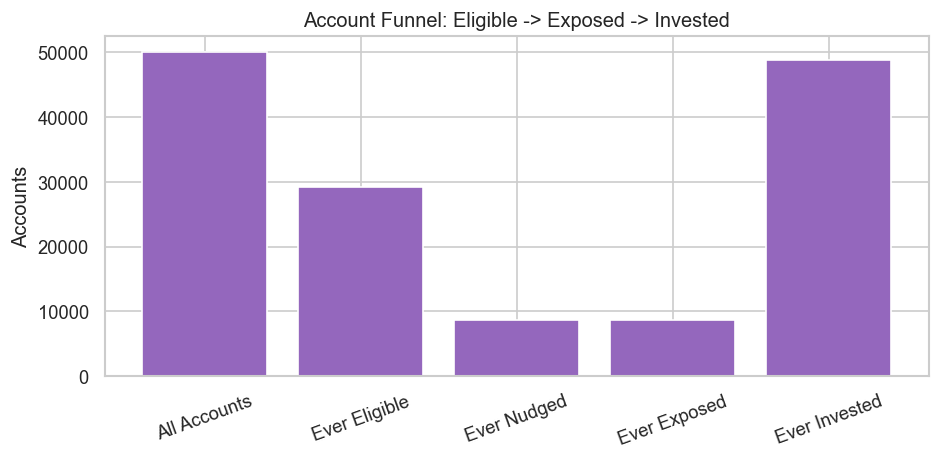

In [80]:

acct_flags = panel.groupby("account_id").agg(
    ever_eligible=("eligible_flag", "max"),
    ever_treated=("treatment_any", "max"),
    ever_exposed=("exposed_any", "max"),
    ever_invested=("invested_flag", "max"),
).reset_index()

funnel = pd.DataFrame({
    "stage": ["All Accounts", "Ever Eligible", "Ever Nudged", "Ever Exposed", "Ever Invested"],
    "count": [
        acct_flags.shape[0],
        int(acct_flags["ever_eligible"].sum()),
        int(acct_flags["ever_treated"].sum()),
        int(acct_flags["ever_exposed"].sum()),
        int(acct_flags["ever_invested"].sum()),
    ],
})
funnel["share_of_all"] = funnel["count"] / funnel.loc[0, "count"]

print("Funnel table")
display(funnel)

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(funnel["stage"], funnel["count"], color="#9467bd")
ax.set_title("Account Funnel: Eligible -> Exposed -> Invested")
ax.set_ylabel("Accounts")
ax.tick_params(axis="x", rotation=20)

plt.tight_layout()
if SAVE_FIGURES:
    fig.savefig(FIG_DIR / "eda_account_funnel.png", dpi=150, bbox_inches="tight")
plt.show()


## 10) Temporal Dynamics (No Causal Claims)

In [81]:

monthly = panel.groupby("calendar_month").agg(
    invest_rate=("invested_flag", "mean"),
    treatment_rate=("treatment_any", "mean"),
    exposure_rate=("exposed_any", "mean"),
    avg_invest_amount=("invest_amount", "mean"),
    avg_market_return=("market_return", "mean"),
    eligible_share=("eligible_flag", "mean"),
).reset_index()

monthly.head()


,calendar_month,invest_rate,treatment_rate,exposure_rate,avg_invest_amount,avg_market_return,eligible_share
0,1970-01-01 00:00:00.000000001,0.04388,0.00000,0.00000,1156.456513,0.011327,0.00000
1,1970-01-01 00:00:00.000000002,0.06230,0.00394,0.00394,1666.156808,0.024345,0.04918
2,1970-01-01 00:00:00.000000003,0.07050,0.00730,0.00730,1947.737161,-0.013566,0.08004
3,1970-01-01 00:00:00.000000004,0.07598,0.00938,0.00938,2079.546205,-0.023260,0.10118
4,1970-01-01 00:00:00.000000005,0.07976,0.01086,0.01086,2179.240722,-0.055755,0.11714


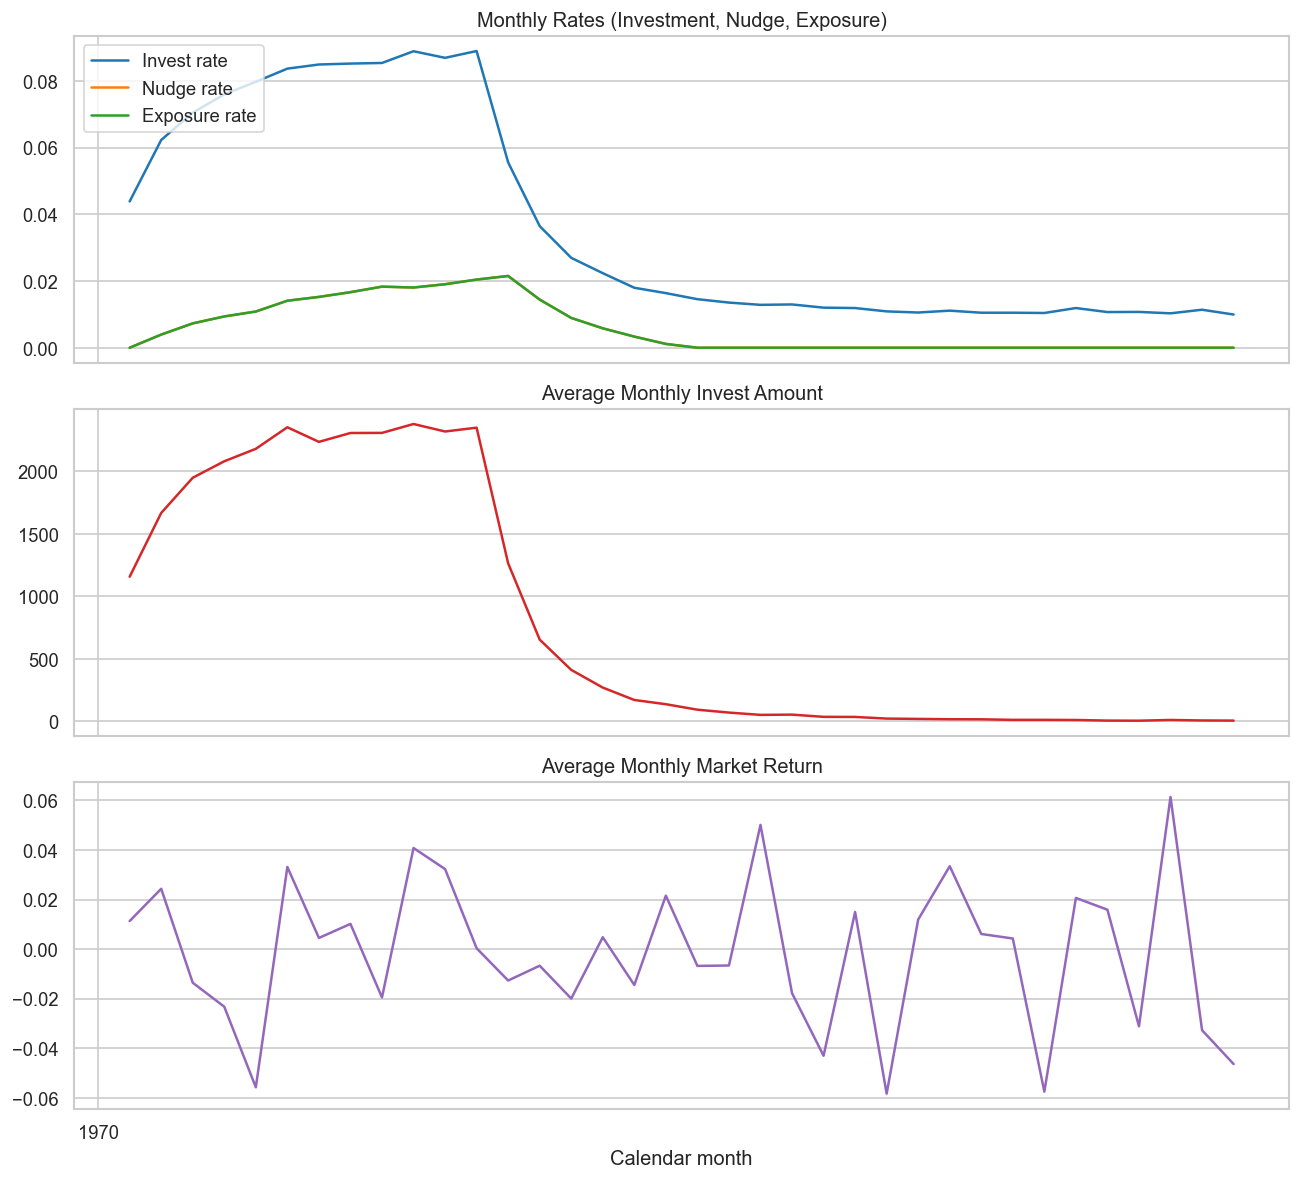

In [82]:

fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)

axes[0].plot(monthly["calendar_month"], monthly["invest_rate"], label="Invest rate", color="#1f77b4")
axes[0].plot(monthly["calendar_month"], monthly["treatment_rate"], label="Nudge rate", color="#ff7f0e")
axes[0].plot(monthly["calendar_month"], monthly["exposure_rate"], label="Exposure rate", color="#2ca02c")
axes[0].legend(loc="upper left")
axes[0].set_title("Monthly Rates (Investment, Nudge, Exposure)")

axes[1].plot(monthly["calendar_month"], monthly["avg_invest_amount"], color="#d62728")
axes[1].set_title("Average Monthly Invest Amount")

axes[2].plot(monthly["calendar_month"], monthly["avg_market_return"], color="#9467bd")
axes[2].set_title("Average Monthly Market Return")
axes[2].set_xlabel("Calendar month")

plt.tight_layout()
if SAVE_FIGURES:
    fig.savefig(FIG_DIR / "eda_monthly_dynamics.png", dpi=150, bbox_inches="tight")
plt.show()


## 11) Lifecycle Behavior by Months Since Rollover

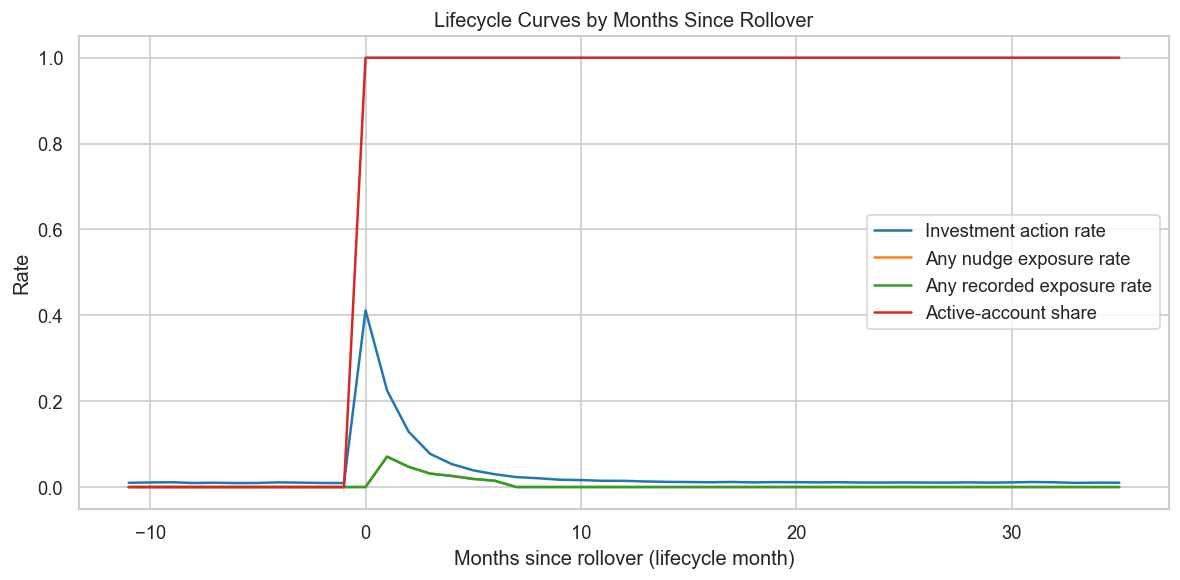

In [83]:
lifecycle = panel.groupby("months_since_rollover").agg(
    investment_action_rate=("invested_flag", "mean"),
    nudge_exposure_rate=("treatment_any", "mean"),
    any_recorded_exposure_rate=("exposed_any", "mean"),
    active_account_share=("active_flag", "mean"),
).reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(lifecycle["months_since_rollover"], lifecycle["investment_action_rate"], label="Investment action rate", color="#1f77b4")
ax.plot(lifecycle["months_since_rollover"], lifecycle["nudge_exposure_rate"], label="Any nudge exposure rate", color="#ff7f0e")
ax.plot(lifecycle["months_since_rollover"], lifecycle["any_recorded_exposure_rate"], label="Any recorded exposure rate", color="#2ca02c")
ax.plot(lifecycle["months_since_rollover"], lifecycle["active_account_share"], label="Active-account share", color="#d62728")
ax.set_title("Lifecycle Curves by Months Since Rollover")
ax.set_xlabel("Months since rollover (lifecycle month)")
ax.set_ylabel("Rate")
ax.legend()

plt.tight_layout()
if SAVE_FIGURES:
    fig.savefig(FIG_DIR / "eda_lifecycle_curves.png", dpi=150, bbox_inches="tight")
plt.show()


## 12) Drift Check (Early vs Late)

In [84]:
# Build an early-vs-late calendar split to quantify cohort drift before modeling.
calendar_series = panel["calendar_month"]
if np.issubdtype(calendar_series.dtype, np.number):
    cutoff_month = calendar_series.median()
else:
    cutoff_month = calendar_series.sort_values().iloc[len(calendar_series) // 2]

early = panel[panel["calendar_month"] <= cutoff_month]
late = panel[panel["calendar_month"] > cutoff_month]

def smd_from_groups(x_early, x_late):
    m_early = x_early.mean()
    m_late = x_late.mean()
    v_early = x_early.var()
    v_late = x_late.var()
    denom = np.sqrt((v_early + v_late) / 2.0)
    if denom == 0 or np.isnan(denom):
        return 0.0
    return (m_early - m_late) / denom

numeric_features = [
    "treatment_any",
    "exposed_any",
    "invested_flag",
    "treatment_intensity",
    "months_since_rollover",
    "market_return",
    "seasonality_index",
    "invest_amount",
    "active_flag",
    "eligible_flag",
]

drift_rows = []
for col in numeric_features:
    s = smd_from_groups(early[col].dropna().to_numpy(), late[col].dropna().to_numpy())
    drift_rows.append({"feature": col, "smd": s, "abs_smd": abs(s)})

# Add account-level attributes to drift table for more realistic pre-model diagnostics.
acct_early = early[["account_id"]].drop_duplicates().merge(accounts, on="account_id", how="left")
acct_late = late[["account_id"]].drop_duplicates().merge(accounts, on="account_id", how="left")

acct_early_num = pd.DataFrame({
    "log_starting_balance": np.log1p(acct_early["baseline_balance"]),
    "digital_engagement_score": acct_early["digital_engagement_score"],
    "advisor_flag": acct_early["advisor_flag"],
    "contactable_email": acct_early["contactable_email"],
    "contactable_sms": acct_early["contactable_sms"],
})
acct_late_num = pd.DataFrame({
    "log_starting_balance": np.log1p(acct_late["baseline_balance"]),
    "digital_engagement_score": acct_late["digital_engagement_score"],
    "advisor_flag": acct_late["advisor_flag"],
    "contactable_email": acct_late["contactable_email"],
    "contactable_sms": acct_late["contactable_sms"],
})

for col in acct_early_num.columns:
    s = smd_from_groups(acct_early_num[col].dropna().to_numpy(), acct_late_num[col].dropna().to_numpy())
    drift_rows.append({"feature": col, "smd": s, "abs_smd": abs(s)})

drift = pd.DataFrame(drift_rows).sort_values("abs_smd", ascending=False)
print("Top drift features (by |SMD|)")
display(drift.head(15))


Top drift features (by |SMD|)


,feature,smd,abs_smd
4,months_since_rollover,-2.883907,2.883907
8,active_flag,-0.902070,0.902070
9,eligible_flag,0.429290,0.429290
2,invested_flag,0.262267,0.262267
7,invest_amount,0.224763,0.224763
5,market_return,0.165605,0.165605
0,treatment_any,0.148980,0.148980
1,exposed_any,0.148980,0.148980
3,treatment_intensity,0.145553,0.145553
6,seasonality_index,-0.132270,0.132270


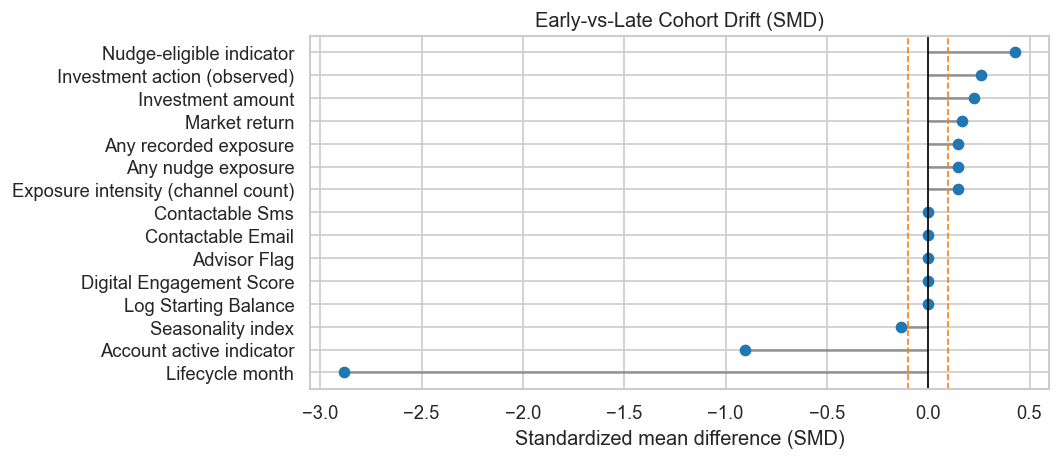

In [85]:
FEATURE_LABELS = {
    "months_since_rollover": "Lifecycle month",
    "treatment_any": "Any nudge exposure",
    "exposed_any": "Any recorded exposure",
    "invested_flag": "Investment action (observed)",
    "treatment_intensity": "Exposure intensity (channel count)",
    "seasonality_index": "Seasonality index",
    "market_return": "Market return",
    "invest_amount": "Investment amount",
    "active_flag": "Account active indicator",
    "eligible_flag": "Nudge-eligible indicator",
}

def feature_label(name):
    return FEATURE_LABELS.get(name, name.replace("_", " ").title())

fig, ax = plt.subplots(figsize=(9, 4))
ordered = drift.sort_values("smd").copy()
ordered["feature_label"] = ordered["feature"].map(feature_label)
ax.hlines(y=ordered["feature_label"], xmin=0, xmax=ordered["smd"], color="#7f7f7f", alpha=0.8)
ax.plot(ordered["smd"], ordered["feature_label"], "o", color="#1f77b4")
ax.axvline(0, color="black", linewidth=1)
ax.axvline(0.1, color="#ff7f0e", linestyle="--", linewidth=1)
ax.axvline(-0.1, color="#ff7f0e", linestyle="--", linewidth=1)
ax.set_title("Early-vs-Late Cohort Drift (SMD)")
ax.set_xlabel("Standardized mean difference (SMD)")

plt.tight_layout()
if SAVE_FIGURES:
    fig.savefig(FIG_DIR / "eda_early_late_smd.png", dpi=150, bbox_inches="tight")
plt.show()


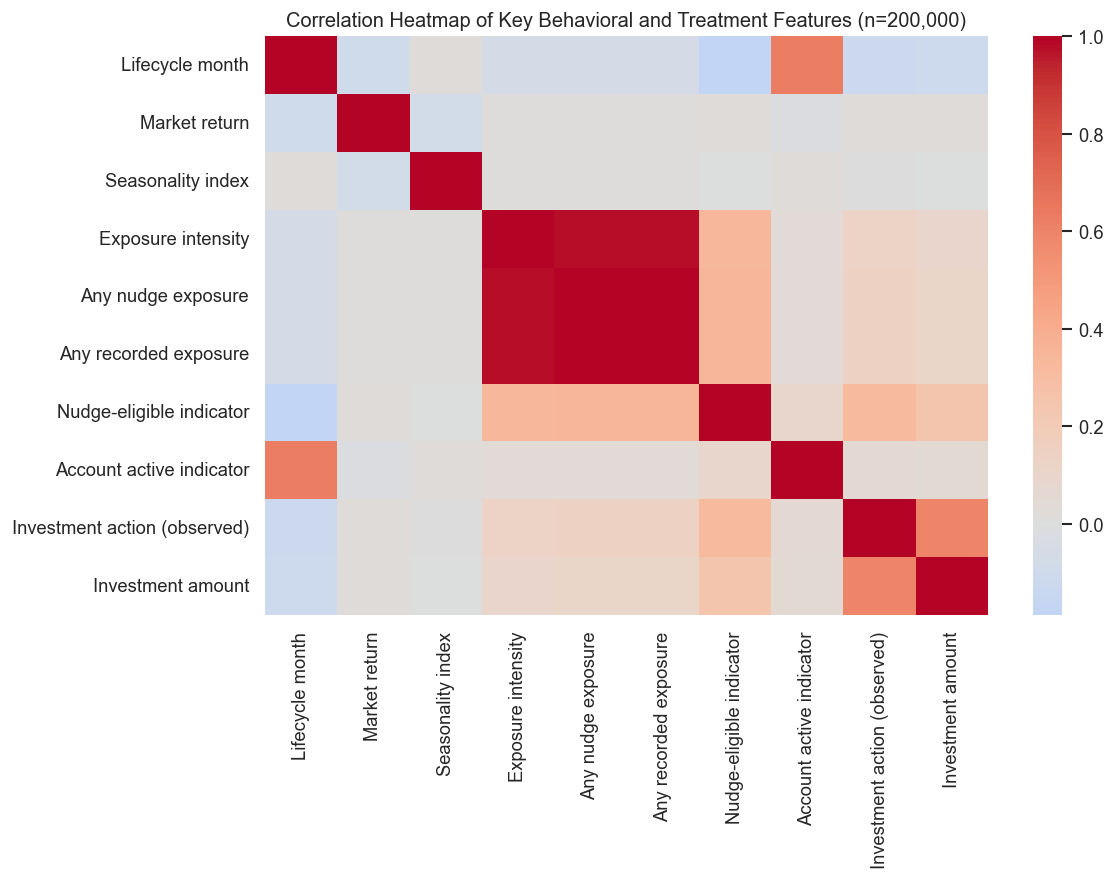

,months_since_rollover,market_return,seasonality_index,treatment_intensity,treatment_any,exposed_any,eligible_flag,active_flag,invested_flag,invest_amount
months_since_rollover,1.000,-0.096,0.018,-0.064,-0.065,-0.065,-0.187,0.633,-0.131,-0.112
market_return,-0.096,1.000,-0.078,0.011,0.011,0.011,0.022,-0.018,0.021,0.018
seasonality_index,0.018,-0.078,1.000,0.012,0.012,0.012,0.000,0.018,0.003,-0.001
treatment_intensity,-0.064,0.011,0.012,1.000,0.979,0.979,0.341,0.031,0.129,0.101
treatment_any,-0.065,0.011,0.012,0.979,1.000,1.000,0.348,0.032,0.133,0.106
exposed_any,-0.065,0.011,0.012,0.979,1.000,1.000,0.348,0.032,0.133,0.106
eligible_flag,-0.187,0.022,0.000,0.341,0.348,0.348,1.000,0.091,0.317,0.247
active_flag,0.633,-0.018,0.018,0.031,0.032,0.032,0.091,1.000,0.060,0.050
invested_flag,-0.131,0.021,0.003,0.129,0.133,0.133,0.317,0.060,1.000,0.594
invest_amount,-0.112,0.018,-0.001,0.101,0.106,0.106,0.247,0.050,0.594,1.000


In [86]:
numeric_cols = [
    "months_since_rollover",
    "market_return",
    "seasonality_index",
    "treatment_intensity",
    "treatment_any",
    "exposed_any",
    "eligible_flag",
    "active_flag",
    "invested_flag",
    "invest_amount",
]

sample_n = min(200_000, len(panel))
sample_df = panel[numeric_cols].sample(sample_n, random_state=42)
corr = sample_df.corr(numeric_only=True)

label_map = {
    "months_since_rollover": "Lifecycle month",
    "market_return": "Market return",
    "seasonality_index": "Seasonality index",
    "treatment_intensity": "Exposure intensity",
    "treatment_any": "Any nudge exposure",
    "exposed_any": "Any recorded exposure",
    "eligible_flag": "Nudge-eligible indicator",
    "active_flag": "Account active indicator",
    "invested_flag": "Investment action (observed)",
    "invest_amount": "Investment amount",
}

corr_display = corr.copy()
corr_display.index = [label_map.get(c, c) for c in corr_display.index]
corr_display.columns = [label_map.get(c, c) for c in corr_display.columns]

fig, ax = plt.subplots(figsize=(10, 7.5))
sns.heatmap(corr_display, cmap="coolwarm", center=0, ax=ax)
ax.set_title(f"Correlation Heatmap of Key Behavioral and Treatment Features (n={sample_n:,})")

plt.tight_layout()
if SAVE_FIGURES:
    fig.savefig(FIG_DIR / "eda_corr_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

corr.round(3)


## 14) Segment Outcome Profile

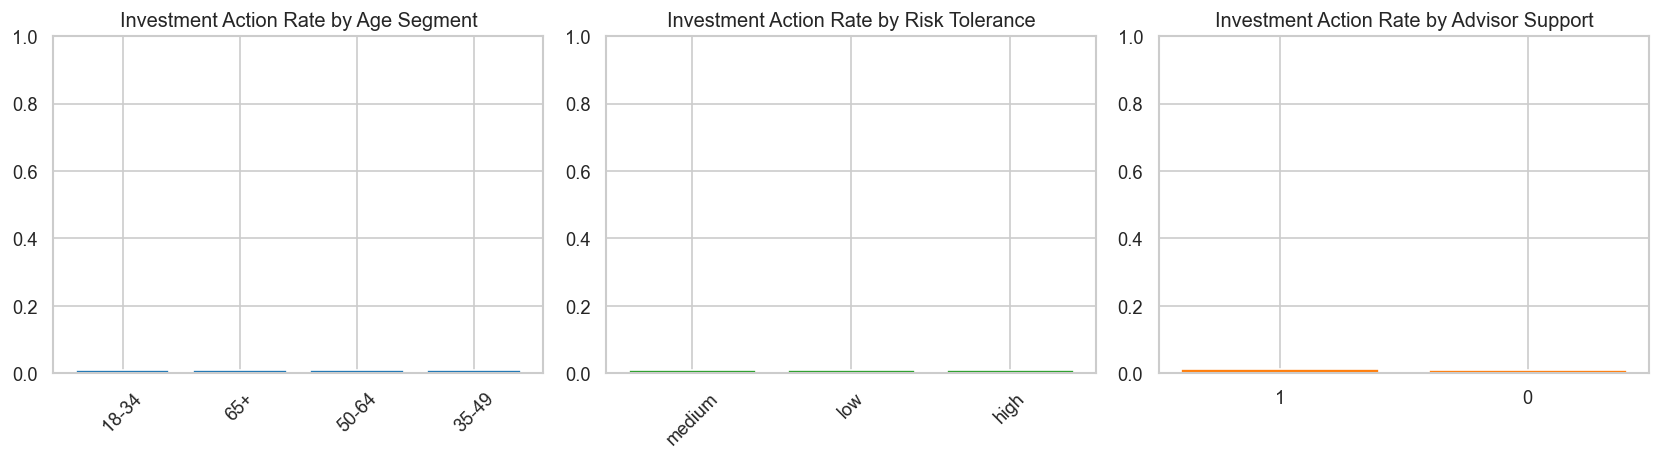

,age_band_invest_rate,risk_tolerance_invest_rate
age_band,,
18-34,0.010664,NaN
65+,0.010377,NaN
50-64,0.009963,NaN
35-49,0.009210,NaN


In [87]:

latest_panel = panel.sort_values("calendar_month").groupby("account_id").tail(1)
segment_df = latest_panel.merge(
    accounts[["account_id", "age_band", "risk_tolerance", "advisor_flag", "preferred_channel"]],
    on="account_id",
    how="left",
)

age_profile = segment_df.groupby("age_band")["invested_flag"].mean().sort_values(ascending=False)
risk_profile = segment_df.groupby("risk_tolerance")["invested_flag"].mean().sort_values(ascending=False)
advisor_profile = segment_df.groupby("advisor_flag")["invested_flag"].mean().sort_values(ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes[0].bar(age_profile.index.astype(str), age_profile.values, color="#1f77b4")
axes[0].set_title("Investment Action Rate by Age Segment")
axes[0].tick_params(axis="x", rotation=45)

axes[1].bar(risk_profile.index.astype(str), risk_profile.values, color="#2ca02c")
axes[1].set_title("Investment Action Rate by Risk Tolerance")
axes[1].tick_params(axis="x", rotation=45)

axes[2].bar(advisor_profile.index.astype(str), advisor_profile.values, color="#ff7f0e")
axes[2].set_title("Investment Action Rate by Advisor Support")

for axis in axes:
    axis.set_ylim(0, 1)

plt.tight_layout()
if SAVE_FIGURES:
    fig.savefig(FIG_DIR / "eda_segment_outcomes.png", dpi=150, bbox_inches="tight")
plt.show()

pd.DataFrame({
    "age_band_invest_rate": age_profile,
    "risk_tolerance_invest_rate": risk_profile.reindex(age_profile.index),
})


## 15) Auto-Summary of Modeling Risks

In [88]:

risk_flags = []

max_missing = float(missing_df["missing_rate"].max())
if max_missing > 0.2:
    risk_flags.append(f"High missingness detected (max={max_missing:.1%}).")

if int(dup_panel_keys) > 0:
    risk_flags.append("Duplicate account-month keys found in panel.")

smd_alerts = drift[drift["smd"].abs() > 0.1]
if len(smd_alerts) > 0:
    risk_flags.append(f"Early/late drift exceeds |0.1| Standardized mean difference (SMD) for {len(smd_alerts)} features.")

if not risk_flags:
    risk_flags = ["No major red flags from these baseline checks."]

print("Potential risk flags")
for i, msg in enumerate(risk_flags, start=1):
    print(f"{i}. {msg}")

print("\nTop 5 missing columns")
print(missing_df.head(5).to_string(index=False))

print("\nFunnel shares")
print(funnel[["stage", "share_of_all"]].to_string(index=False))


Potential risk flags
1. High missingness detected (max=86.7%).
2. Early/late drift exceeds |0.1| Standardized mean difference (SMD) for 10 features.

Top 5 missing columns
           column  missing_rate
       event_time      0.867294
   engagement_obs      0.050108
market_return_obs      0.020017
       account_id      0.000000
   calendar_month      0.000000

Funnel shares
        stage  share_of_all
 All Accounts       1.00000
Ever Eligible       0.58452
  Ever Nudged       0.17276
 Ever Exposed       0.17276
Ever Invested       0.97692
